## a review of mapping in yt

This notebook describes the current state of the geopgraphic datasets in *yt*.



### some boilerplate

Ok, first off, let's just dump a bunch of functions to load the netcdf data into yt. 

First, a function to return an `internal_geographic` dataset that covers a subset of the globe:

In [66]:
import xarray as xr
import yt
import os
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs

ddir = os.path.join(yt.config.ytcfg.get('yt','test_data_dir'), 'sample_nc')
             
datasets = {
    "internal_geographic_partial": os.path.join(ddir,'wUS-SH-2010_percent.nc'), 
    "internal_geographic_global": os.path.join(ddir,'GYPSUM_percent.nc'), 
}

def get_internal_IRIS(case,latrng=None,lonrng=None):
    # both datasets have the same variables and dimension order
    
    fi = datasets[case]

    with xr.open_dataset(fi) as xr_ds:
        dvs = xr_ds.dvs.to_masked_array().data
        deprng = [xr_ds.depth.data.min(), xr_ds.depth.data.max()]
        if latrng is None:
            lonrng=[xr_ds.longitude.data.min(), xr_ds.longitude.data.max()]
        if latrng is None:
            latrng=[xr_ds.latitude.data.min(), xr_ds.latitude.data.max()]

    data = {'dvs': (dvs, "%")}
    
    bbox = np.array([
      deprng,   
      latrng,
      lonrng
    ])

    dims = ['depth', 'latitude', 'longitude']

    return yt.load_uniform_grid(data, data['dvs'][0].shape, 1.0, 
                                geometry=("internal_geographic", dims),
                                bbox=bbox)

## first problem: 

When working with a dataset that does not cover the whole globe, trying to make a slice plot hangs. This is related to some odd kdtree sampling behavior. In `base_plot_types.ImagePlotMPL` at line 249, there's the following:

```python
        if hasattr(self.axes, "set_extent"):
            # CartoPy hangs if we do not set_extent before imshow if we are
            # displaying a small subset of the globe.  What I believe happens is
            # that the transform for the points on the outside results in
            # infinities, and then the scipy.spatial cKDTree hangs trying to
            # identify nearest points.
            #
            # Also, set_extent is defined by cartopy, so not all axes will have
            # it as a method.
            #
            # A potential downside is that other images may change, but I believe
            # the result of imshow is to set_extent *regardless*.  This just
            # changes the order in which it happens.
            #
            # NOTE: This is currently commented out because it breaks in some
            # instances.  It is left as a historical note because we will
            # eventually need some form of it.
            # self.axes.set_extent(extent)
            pass
```

For now, uncommenting the `self.axes.set_extent` line seems to work. Investigations are underway.... but the rest of the notebook assumes this line is uncommented. 

## onto a plot

Ok, so let's slice and plot our data, adding some shapefile features vs `cartopy.feature`:

In [4]:
ds = get_internal_IRIS("internal_geographic_partial")

yt : [INFO     ] 2021-05-13 15:26:14,977 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-13 15:26:14,978 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2021-05-13 15:26:14,978 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2021-05-13 15:26:14,980 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2021-05-13 15:26:14,981 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2021-05-13 15:26:17,264 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 15:26:17,388 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 15:26:17,388 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 15:26:17,389 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 15:26:17,389 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 15:26:17,391 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 15:26:17,423 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -14.010000, Max = 8.820000.
yt : [WARNING  ] 2021-05-13 15:26:17,424 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



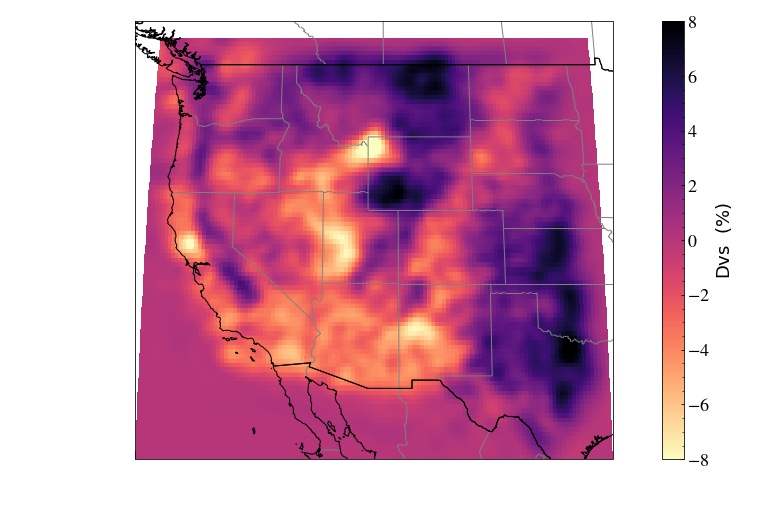

In [ ]:

c = ds.domain_center
c[0] = 100
p = yt.SlicePlot(ds,'depth','dvs',center=c)
p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')

p._setup_plotsz()
carto_ax = p.plots['dvs'].axes
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_1_states_provinces_lines', '10m',
        edgecolor='gray', facecolor='none'))
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '10m',
        edgecolor='black', facecolor='none'))

p.show()

**improvement 1** : would be convenient to expose `add_feature` within the slice object more directly for geographic datasets to avoid having to manually call `_setup_plots` and pull out the cartopy axis. i.e., it'd be nice to be able to call

```python
import cartopy.feature as cfeature

p = yt.SlicePlot(ds,'depth','dvs',center=c)
the_cfeature=cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '10m',
                                            edgecolor='gray', facecolor='none')
p.add_feature('dvs', the_cfeature)
```

to add the feature to the `dvs` plot. Would only want to expose this for geographic projection plots, probably in map view only (fixed depth or altitude, not slices along lat/lon)? 

## map inset/zoom plots

So we can easily zoom in to a smaller region with


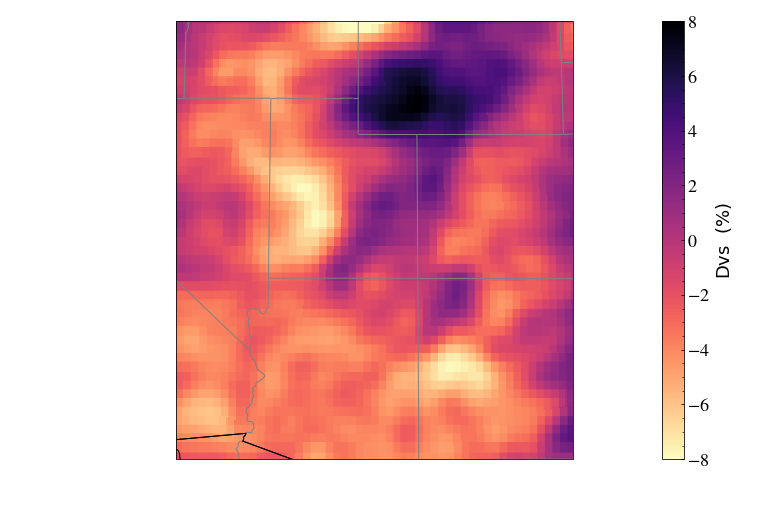

In [6]:
carto_ax.set_extent((-117, -104, 32, 44))
p.show()

and that's great! but for a publication ready figure, we often need plots like this side-by-side. 

But creating a multi-plot with cartopy axes is hard.... To illustrate, following the docs [here](https://yt-project.org/doc/cookbook/complex_plots.html#multipanel-with-axes-labels):

yt : [INFO     ] 2021-05-13 11:19:51,876 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 11:19:51,879 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 11:19:51,880 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 11:19:51,882 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 11:19:51,882 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 11:19:51,885 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 11:19:51,916 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -14.010000, Max = 8.820000.
yt : [WARNING  ] 2021-05-13 11:19:51,916 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later
yt : [INFO     ] 2021-05-13 11:20:01,395 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 11:20:01,396 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 11:20:01,397 ylim

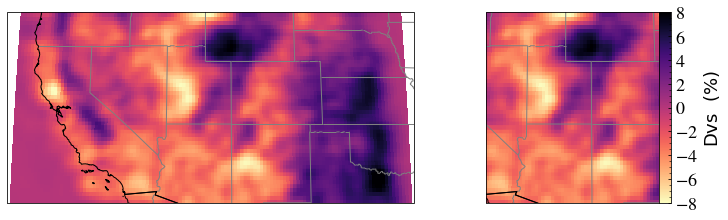

In [10]:
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import AxesGrid

def get_slice():
    p = yt.SlicePlot(ds, "depth", 'dvs',center=c)
    p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
    p.set_log('dvs',False)
    p.set_zlim('dvs',-8, 8)
    p.set_cmap('dvs','magma_r')
    return p


def add_features(carto_ax):
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_1_states_provinces_lines', '10m',
            edgecolor='gray', facecolor='none'))
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none'))
        

    
p = get_slice()


fig = plt.figure()

plot = p.plots[('stream', 'dvs')]
carto_ax = plot.axes
axes_class = (type(carto_ax), dict(map_projection=carto_ax.projection))
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (1, 2),
                axes_class=axes_class,
                axes_pad = 1.0,
                share_all = False,
                cbar_location="right",
                cbar_mode="single",
                cbar_size="3%",
                cbar_pad="0%",
                label_mode='') # label model needs to be empty?


p.plots[('stream', 'dvs')].figure = fig
p.plots[('stream', 'dvs')].axes = grid[0].axes
p.plots[('stream', 'dvs')].cax = grid.cbar_axes[0]
p._setup_plots()
add_features(p.plots[('stream', 'dvs')].axes)


p_2 = get_slice() # need another slice just to be sure...  
p_2.plots[('stream', 'dvs')].figure = fig
p_2.plots[('stream', 'dvs')].axes = grid[1].axes
p_2.plots[('stream', 'dvs')].cax = grid.cbar_axes[1]
p_2._setup_plots()
add_features(p_2.plots[('stream', 'dvs')].axes)
p_2.plots[('stream', 'dvs')].axes.set_extent((-117, -104, 32, 44))

Weird, why is the full-US map truncated? Maybe if we manually set extent on the first, as well:

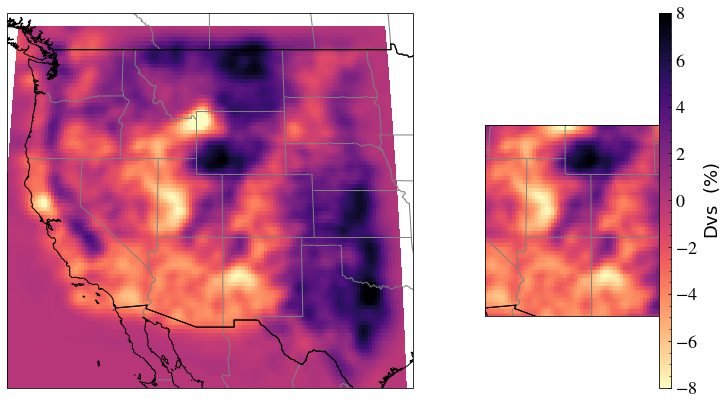

In [14]:
p.plots[('stream', 'dvs')].axes.set_extent((-110-15., -110+15., 39-11.5, 39+11.5))

fig

Ok, so that is a slight improvemement, at least it shows everything.... 

but ideally the relative sizes should be reversed (the smaller extent should be visually larger). How to control that??? looks like the pixel sizes are the same in both subplots.

meaning something like this (from photoshop):


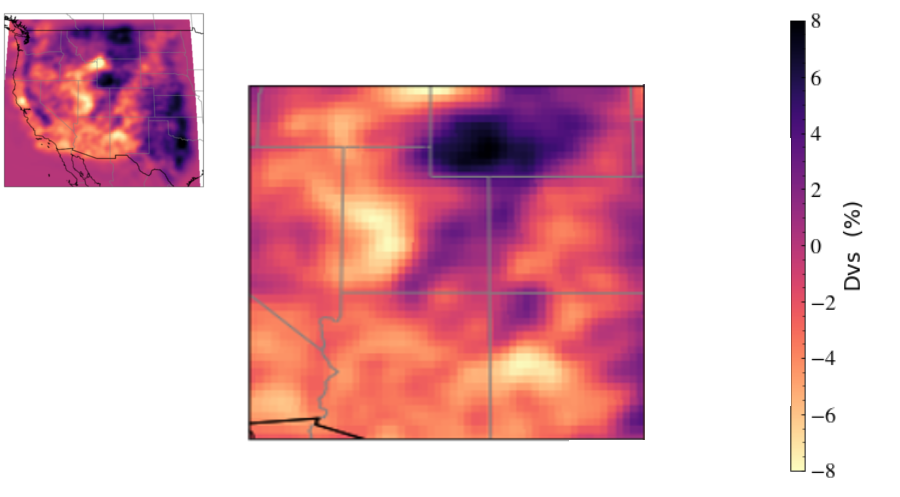

what's the best way to achieve this? 

Not really sure... one approach is to generate image buffers of two separate slices and combine/scale them into a new image. 


So here's a function that uses the matplotlib `canvas.buffer_rgba()` function to create a series of images to scale:

In [15]:
def canvas_to_buff(yt_im):
    # draw the canvas and get buffer
    yt_im.canvas.draw()
    buf = yt_im.canvas.buffer_rgba()
    from PIL import Image
    im = Image.fromarray(np.asarray(buf))
    return im

so we can generate image buffers from two slices:

In [20]:
p = get_slice()
p._setup_plots()
p.hide_colorbar()
add_features(p.plots[('stream', 'dvs')].axes)

im_region = canvas_to_buff(p.plots[('stream', 'dvs')])

yt : [INFO     ] 2021-05-13 11:40:33,137 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 11:40:33,142 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 11:40:33,144 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 11:40:33,147 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 11:40:33,147 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 11:40:33,150 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 11:40:33,180 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -14.010000, Max = 8.820000.
yt : [WARNING  ] 2021-05-13 11:40:33,181 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later


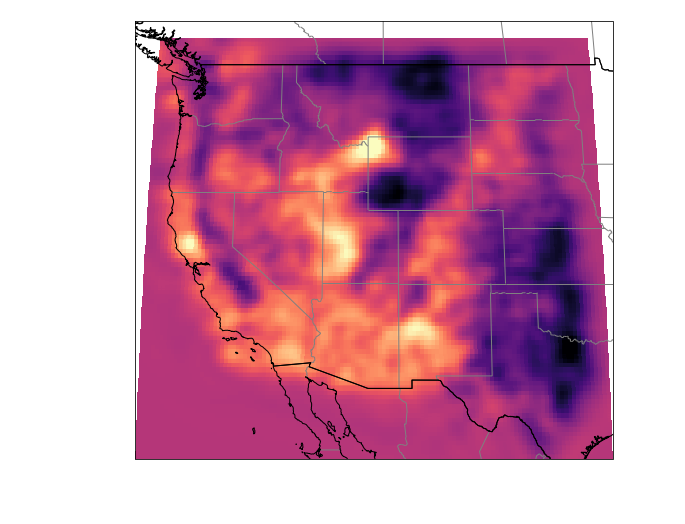

In [21]:
im_region

In [24]:
p.plots[('stream', 'dvs')].axes.set_extent((-117, -104, 32, 44))
p.show_colorbar()
im_local = canvas_to_buff(p.plots[('stream', 'dvs')])

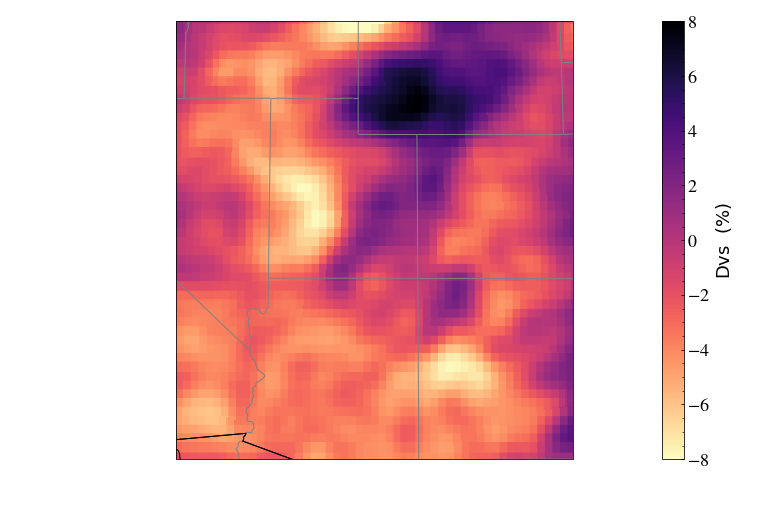

In [25]:
im_local

and then scale and combine into a new image:

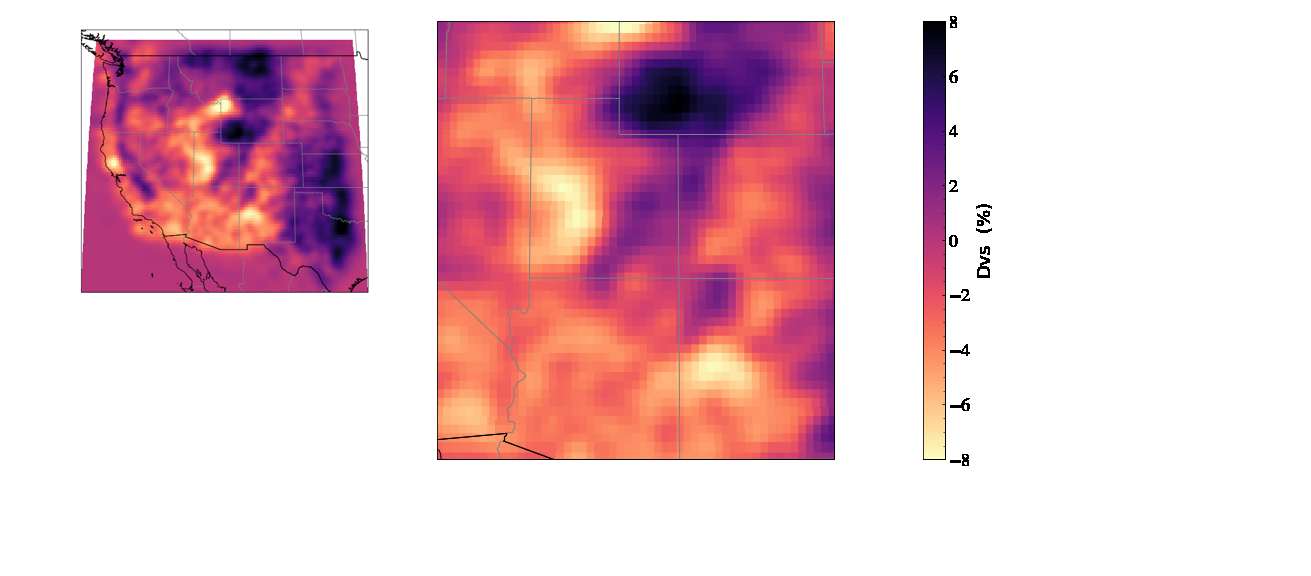

In [26]:
from PIL import Image

# paste in our regional plot to a new image (fixes issue with image background)
new_WUS = Image.new('RGB', im_region.size, color='white')
new_WUS.paste(im_region, (0, 0))

# resize it!
WUS_small = new_WUS.resize([int(0.6 * sz) for sz in new_WUS.size])

# on the new height and widht for the combo image
new_height = int(1.1 * np.max([im_local.size[1], WUS_small.size[1]]))
new_width = int(1.1 * (im_local.size[0] + WUS_small.size[0]))

# initialize our new image
new_im = Image.new('RGB', (new_width,new_height), color='white')

# paste in our scaled images
new_im.paste(im_local, (WUS_small.size[0]-150,0))
new_im.paste(WUS_small, (0,17))


new_im

Close! colorbar font isn't great though... what about a matplotlib approach. maybe `gridspec`?

yt : [INFO     ] 2021-05-13 12:44:18,585 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 12:44:18,587 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 12:44:18,587 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 12:44:18,588 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 12:44:18,588 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 12:44:18,590 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 12:44:18,613 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -14.010000, Max = 8.820000.
yt : [WARNING  ] 2021-05-13 12:44:18,614 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later
yt : [INFO     ] 2021-05-13 12:44:27,171 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 12:44:27,173 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 12:44:27,173 ylim

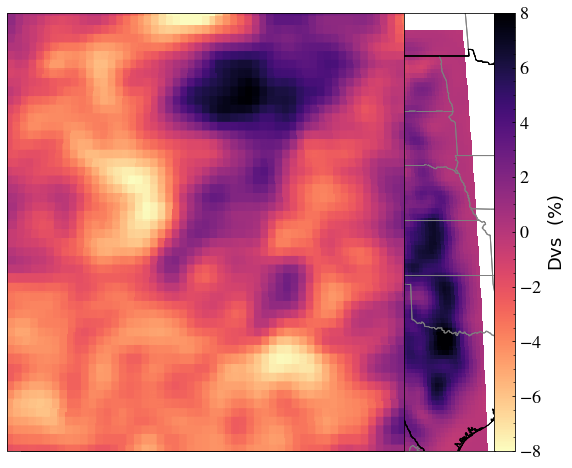

In [78]:
from matplotlib import gridspec

p = get_slice()
proj = p.plots[('stream','dvs')].axes.projection

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[1, .1, 3, .1]) 

ax0 = plt.subplot(gs[0], projection = proj)
ax0_cmap = plt.subplot(gs[1])
ax1 = plt.subplot(gs[2], projection = proj)
ax1_cmap = plt.subplot(gs[3])


p = get_slice()
p.plots[('stream', 'dvs')].figure = fig
p.plots[('stream', 'dvs')].axes = ax0
p.plots[('stream', 'dvs')].cax = ax0_cmap
p._setup_plots()
p.hide_colorbar()
add_features(p.plots[('stream', 'dvs')].axes)
p.plots[('stream', 'dvs')].axes.set_extent((-110-15., -110+15., 39-11.5, 39+11.5))

p2 = get_slice()
p2.plots[('stream', 'dvs')].figure = fig
p2.plots[('stream', 'dvs')].axes = ax1
p2.plots[('stream', 'dvs')].cax = ax1_cmap
p2._setup_plots()
add_features(p.plots[('stream', 'dvs')].axes)
p2.plots[('stream', 'dvs')].axes.set_extent((-117, -104, 32, 44))



errr..... what about manual axes. 

test:

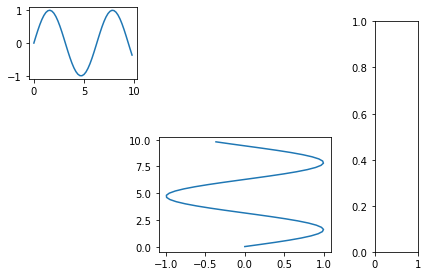

In [61]:

import numpy as np
x = np.arange(0, 10, 0.2)
y = np.sin(x)


# definitions for the axes
small_map = [0.1, 0.7, 0.25, 0.25] # (left, bottom, width, height)
big_map = [0.4, 0.1, 0.4, 0.4]
cmap_box = [0.9, 0.1, 0.1, 0.8]

fig = plt.figure()

small_map_ax = plt.axes(small_map)
big_map_ax = plt.axes(big_map)
cmap_ax = plt.axes(cmap_box)

small_map_ax.plot(x, y)
big_map_ax.plot(y, x)

plt.show()

and let's try it with the slices:

yt : [INFO     ] 2021-05-13 12:50:04,205 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 12:50:04,207 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 12:50:04,207 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 12:50:04,208 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 12:50:04,209 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 12:50:04,210 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 12:50:04,233 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -14.010000, Max = 8.820000.
yt : [WARNING  ] 2021-05-13 12:50:04,233 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later
yt : [INFO     ] 2021-05-13 12:50:12,738 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 12:50:12,739 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 12:50:12,739 ylim

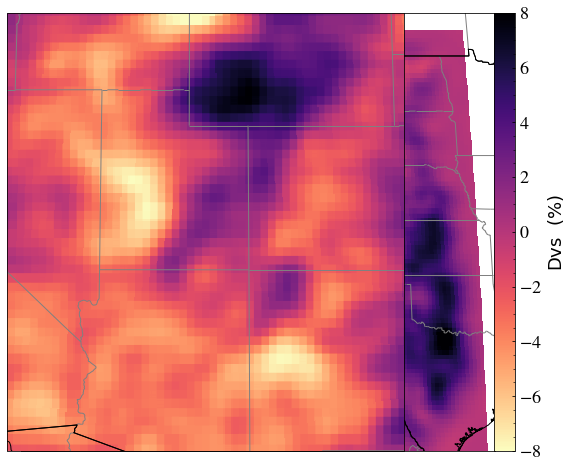

In [81]:

p = yt.SlicePlot(ds, "depth", 'dvs',center=c)
p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
proj = p.plots[('stream','dvs')].axes.projection


small_map = [0.1, 0.7, 0.25, 0.25] # (left, bottom, width, height)
small_cmap = [0.3, 0.7, 0.1, 0.25]
big_map = [0.4, 0.1, 0.4, 0.4]
cmap_box = [0.9, 0.1, 0.1, 0.8]

fig = plt.figure()
small_map_ax = plt.axes(small_map, projection = proj)
small_cmap_ax = plt.axes(small_cmap)
big_map_ax = plt.axes(big_map, projection = proj)
cmap_ax = plt.axes(cmap_box)


p = get_slice()
p.hide_colorbar()
plot = p.plots[('stream', 'dvs')]
plot.figure = fig
plot.axes = small_map_ax
plot.cax = small_cmap_ax
p._setup_plots()

add_features(plot.axes)
plot.axes.set_extent((-110-15., -110+15., 39-11.5, 39+11.5))

p2 = get_slice()
plot = p2.plots[('stream', 'dvs')]
plot.figure = fig
plot.axes = big_map_ax
plot.cax = cmap_ax
p2._setup_plots()
add_features(plot.axes)
plot.axes.set_extent((-117, -104, 32, 44))


yikes. ok, dunno.

### global plots

Some issues:

if the lon/lat range is exactly (-180, 180) and (-90,90), get errors while slicing:

In [83]:
ds = get_internal_IRIS("internal_geographic_global")

yt : [INFO     ] 2021-05-13 12:52:39,506 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-13 12:52:39,506 Parameters: domain_dimensions         = [100 181 361]
yt : [INFO     ] 2021-05-13 12:52:39,507 Parameters: domain_left_edge          = [   0.  -90. -180.]
yt : [INFO     ] 2021-05-13 12:52:39,507 Parameters: domain_right_edge         = [2900.   90.  180.]
yt : [INFO     ] 2021-05-13 12:52:39,508 Parameters: cosmological_simulation   = 0


In [85]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

c = ds.domain_center
c[0] = 100
p = yt.SlicePlot(ds,'depth','dvs',center=c)
p.set_mpl_projection(('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')


yt : [INFO     ] 2021-05-13 12:53:20,522 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 12:53:20,528 xlim = -180.000000 180.000000
yt : [INFO     ] 2021-05-13 12:53:20,529 ylim = -90.000000 90.000000
yt : [INFO     ] 2021-05-13 12:53:20,531 xlim = -180.000000 180.000000
yt : [INFO     ] 2021-05-13 12:53:20,531 ylim = -90.000000 90.000000
yt : [INFO     ] 2021-05-13 12:53:20,533 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 12:53:20,575 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2021-05-13 12:53:20,576 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later


ValueError: Failed to determine the required bounds in projection coordinates. Check that the values provided are within the valid range (x_limits=[-18040095.696147293, 18040095.696147293], y_limits=[-9020047.848073646, 9020047.848073646]).

Yikes! Turns out our bounds can't be exactly -180 to 180 or -90 to 90....

So if we provide some bounds close to the full, it at least plots.

In [103]:
ds = get_internal_IRIS("internal_geographic_global", latrng = [-89., 89.], lonrng = [-179., 179.])

yt : [INFO     ] 2021-05-13 13:00:37,172 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-13 13:00:37,172 Parameters: domain_dimensions         = [100 181 361]
yt : [INFO     ] 2021-05-13 13:00:37,173 Parameters: domain_left_edge          = [   0.  -89. -179.]
yt : [INFO     ] 2021-05-13 13:00:37,174 Parameters: domain_right_edge         = [2900.   89.  179.]
yt : [INFO     ] 2021-05-13 13:00:37,175 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2021-05-13 13:06:01,704 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:06:01,708 xlim = -179.000000 179.000000
yt : [INFO     ] 2021-05-13 13:06:01,709 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:06:01,711 xlim = -179.000000 179.000000
yt : [INFO     ] 2021-05-13 13:06:01,711 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:06:01,713 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:06:01,750 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2021-05-13 13:06:01,750 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



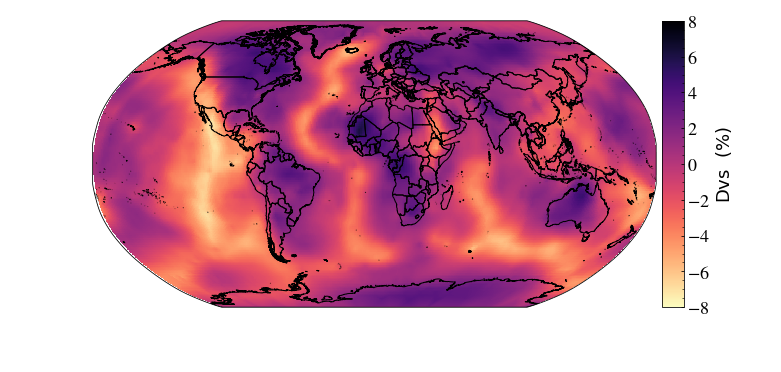

In [112]:
c = ds.domain_center
c[0] = 100
p = yt.SlicePlot(ds,'depth','dvs', center=c)
p.set_mpl_projection('Robinson')
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')

p._setup_plots()
carto_ax = p.plots['dvs'].axes
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '10m',
        edgecolor='black', facecolor='none'))
p.show()

ok, what if we want to shift the center point?

yt : [INFO     ] 2021-05-13 13:15:25,007 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:15:25,016 xlim = -179.000000 179.000000
yt : [INFO     ] 2021-05-13 13:15:25,016 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:15:25,017 xlim = -179.000000 179.000000
yt : [INFO     ] 2021-05-13 13:15:25,017 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:15:25,019 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:15:25,052 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2021-05-13 13:15:25,052 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



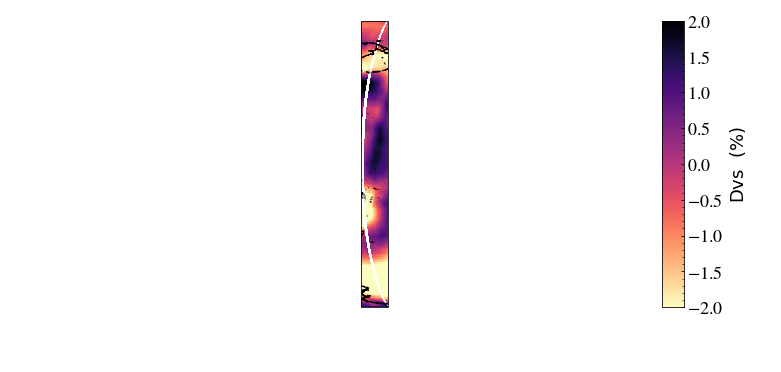

In [129]:
c = ds.domain_center
c[0] = 100
p = yt.SlicePlot(ds,'depth','dvs', center=c)
p.set_mpl_projection(('Robinson', () , {'central_longitude':-145., 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')

p._setup_plots()
carto_ax = p.plots['dvs'].axes
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '10m',
        edgecolor='black', facecolor='none'))
p.show()

Oh yikes. maybe we also need to `set_extent`?

yt : [INFO     ] 2021-05-13 13:15:45,775 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:15:45,778 xlim = -179.000000 179.000000
yt : [INFO     ] 2021-05-13 13:15:45,778 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:15:45,779 xlim = -179.000000 179.000000
yt : [INFO     ] 2021-05-13 13:15:45,779 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:15:45,781 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:15:45,814 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2021-05-13 13:15:45,814 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



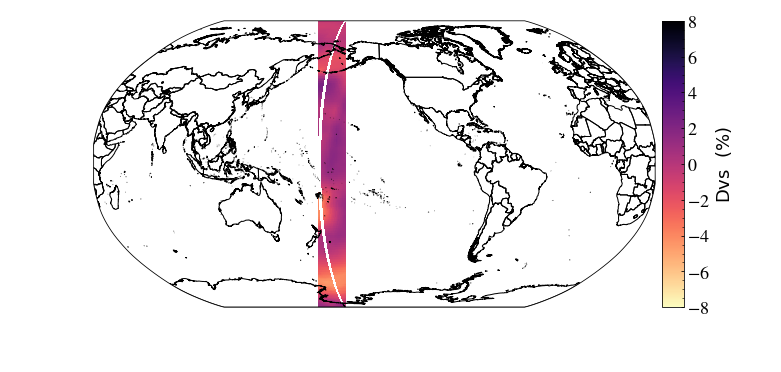

In [130]:
center_lon = -145.
c = ds.domain_center
c[0] = 100
p = yt.SlicePlot(ds,'depth','dvs', center=c)
p.set_mpl_projection(('Robinson', () , {'central_longitude':center_lon, 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')

p._setup_plots()
carto_ax = p.plots['dvs'].axes
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '10m',
        edgecolor='black', facecolor='none'))

carto_ax.set_extent((center_lon - 179, center_lon+179, -90, 90))

p.show()


oh. hmm. err. ?


oh, maybe we ALSO need to adjust our slice??

yt : [INFO     ] 2021-05-13 13:18:00,873 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:18:00,878 xlim = -324.000000 34.000000
yt : [INFO     ] 2021-05-13 13:18:00,878 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:18:00,880 xlim = -324.000000 34.000000
yt : [INFO     ] 2021-05-13 13:18:00,881 ylim = -89.000000 89.000000
yt : [INFO     ] 2021-05-13 13:18:00,883 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:18:00,925 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2021-05-13 13:18:00,925 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



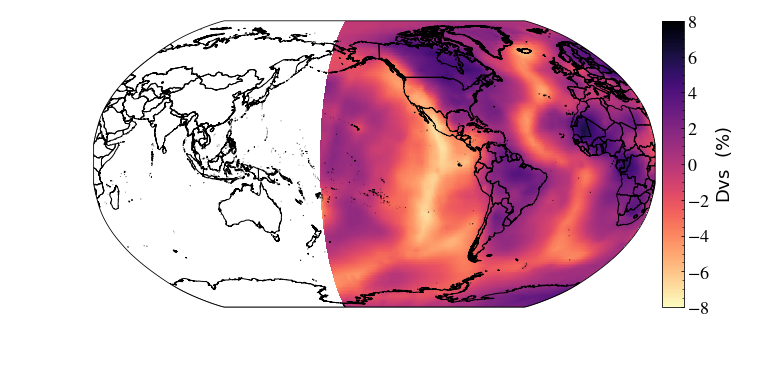

In [133]:
center_lon = -145.
c = ds.domain_center
c[0] = 100
c[2] = center_lon
p = yt.SlicePlot(ds,'depth','dvs', center=c)

p.set_mpl_projection(('Robinson', () , {'central_longitude':center_lon, 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')

p._setup_plots()
carto_ax = p.plots['dvs'].axes
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '10m',
        edgecolor='black', facecolor='none'))

carto_ax.set_extent((center_lon - 179, center_lon+179, -90, 90))

p.show()




fascinating. does setting the slice `width` help?

yt : [INFO     ] 2021-05-13 13:18:11,595 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:18:11,598 xlim = -324.500000 34.500000
yt : [INFO     ] 2021-05-13 13:18:11,599 ylim = -90.000000 90.000000
yt : [INFO     ] 2021-05-13 13:18:11,600 xlim = -324.500000 34.500000
yt : [INFO     ] 2021-05-13 13:18:11,601 ylim = -90.000000 90.000000
yt : [INFO     ] 2021-05-13 13:18:11,603 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:18:11,639 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -7.125200, Max = 6.229640.
yt : [WARNING  ] 2021-05-13 13:18:11,640 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



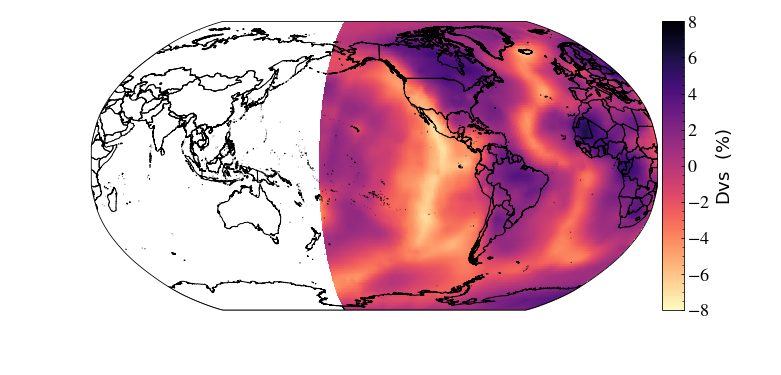

In [134]:


center_lon = -145.
c = ds.domain_center
c[0] = 100
c[2] = center_lon
p = yt.SlicePlot(ds,'depth','dvs', center=c, width= ((359, 'code_length'), (180, 'code_length')))
p.set_mpl_projection(('Robinson', () , {'central_longitude':center_lon, 'globe':None} ))
p.set_log('dvs',False)
p.set_zlim('dvs',-8, 8)
p.set_cmap('dvs','magma_r')

p._setup_plots()
carto_ax = p.plots['dvs'].axes
carto_ax.add_feature(cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '10m',
        edgecolor='black', facecolor='none'))

carto_ax.set_extent((center_lon - 179, center_lon+179, -90, 90))

p.show()

no.

might be an issue with periodic sampling? or??


## fixed lat/lon slices

These don't make much sense from a geoscience perspective... 

yt : [INFO     ] 2021-05-13 13:24:05,328 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:24:05,331 xlim = 0.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:05,331 ylim = -2900.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:05,332 xlim = 0.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:05,333 ylim = -2900.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:05,333 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:24:05,378 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -4.014560, Max = 4.356020.
yt : [WARNING  ] 2021-05-13 13:24:05,378 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



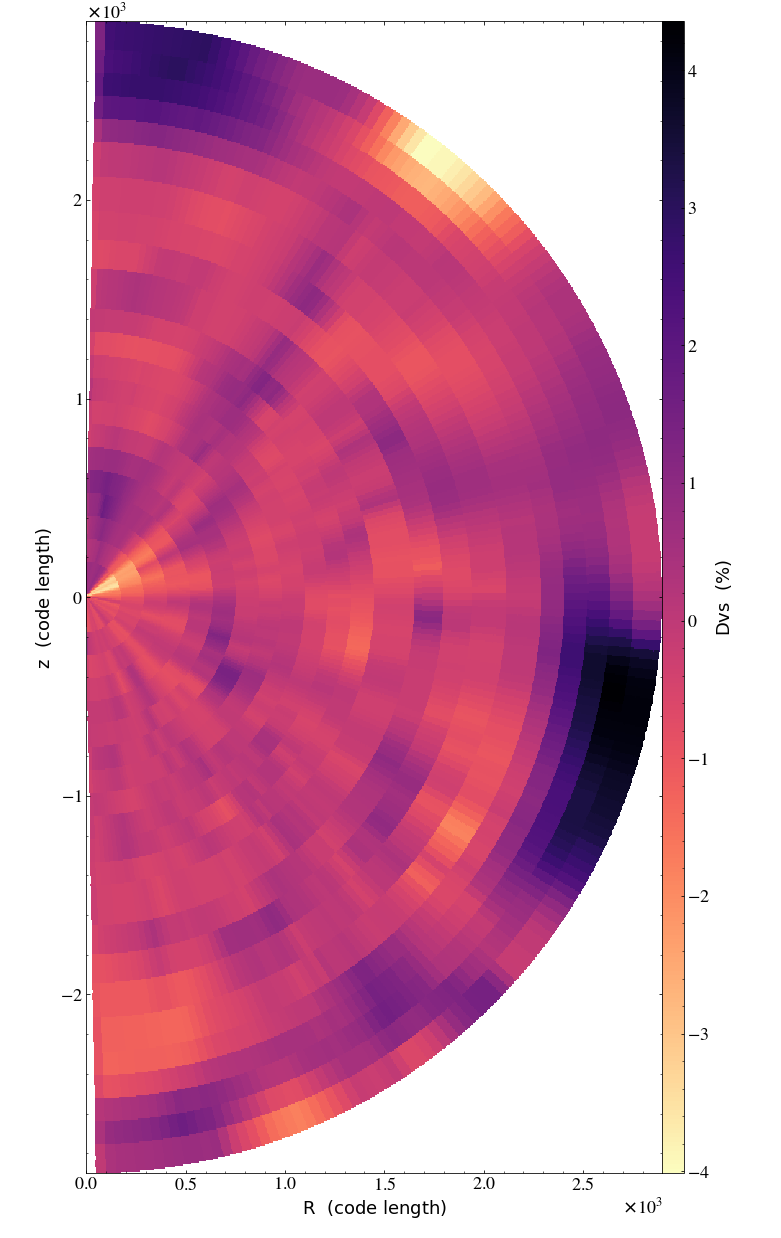

In [141]:
p = yt.SlicePlot(ds,'longitude','dvs')
p.set_log('dvs',False)
p.set_cmap('dvs','magma_r')

yt : [INFO     ] 2021-05-13 13:24:15,562 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 13:24:15,571 xlim = -2900.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:15,571 ylim = -2900.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:15,572 xlim = -2900.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:15,572 ylim = -2900.000000 2900.000000
yt : [INFO     ] 2021-05-13 13:24:15,573 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 13:24:15,617 Plot image for field ('stream', 'dvs') has both positive and negative/zero values. Min = -6.488730, Max = 5.003620.
yt : [WARNING  ] 2021-05-13 13:24:15,618 Log-scaling specified: switching to symlog colorbar scaling unless linear scaling is specified later



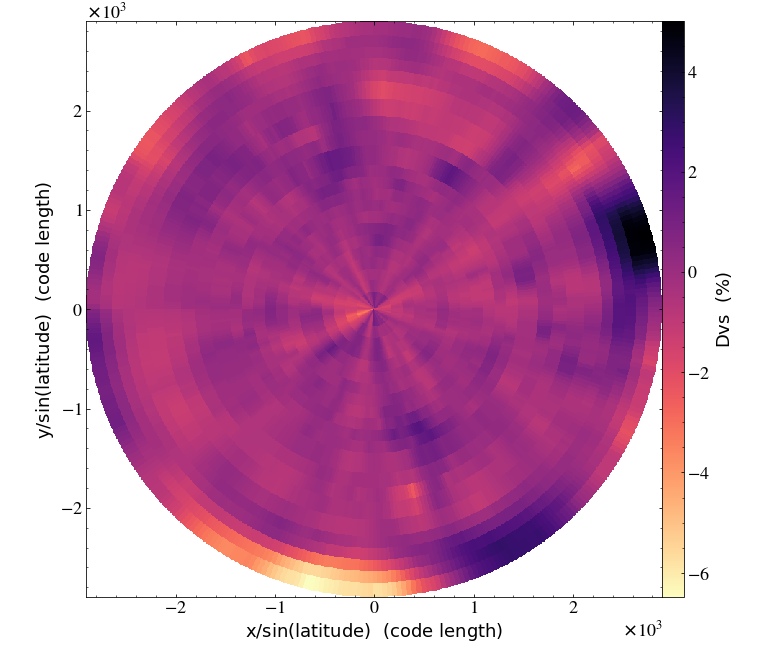

In [142]:
p = yt.SlicePlot(ds,'latitude','dvs')
p.set_log('dvs',False)
p.set_cmap('dvs','magma_r')

What would be useful is a cross-section plot. This is typically a slice along a great-circle arc, e.g.:

![crss](https://ds.iris.edu/media/product/emc-sawum_na2/images/SAWum_NA2_display.png)

The "horizontal" axis there is the angle along the great circle path. 

Sometimes you see these for global models as well. [this presentation](https://www.college-de-france.fr/media/en-barbara-romanowicz/UPL5092693093507512148_18_barbara_romanowicz_2018.pdf) has a nice assortment of figure types.

yt : [INFO     ] 2021-05-13 15:46:23,585 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2021-05-13 15:46:23,585 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2021-05-13 15:46:23,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-05-13 15:46:23,586 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-05-13 15:46:23,587 Parameters: cosmological_simulation   = 0
Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 20106.81it/s]
yt : [INFO     ] 2021-05-13 15:46:23,603 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2021-05-13 15:46:26,921 Projection completed
yt : [INFO     ] 2021-05-13 15:46:26,922 xlim = 0.000000 1.000000
yt : [INFO     ] 2021-05-13 15:46:26,922 ylim = 0.000000 1.000000
yt : [INFO     ] 2021-05-13 15:46:26,923 xlim = 0.000000 1.000000
yt : [INFO     ] 2021-05-13 15:46:26,924 ylim = 0.000000 1.000000
yt : [INFO     ] 2021-05-13 15:46:26,925 Making a fi


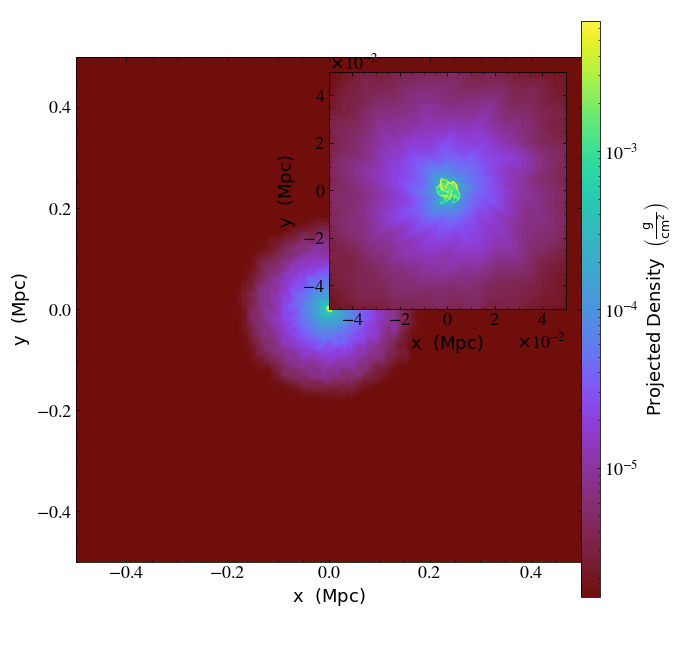

In [7]:
import yt

ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")

p = yt.ProjectionPlot(ds, "z", "density")
p._setup_plots()

ax2 = p.plots["density"].axes.inset_axes([0.5, 0.5, 0.47, 0.47])

p2 = yt.ProjectionPlot(ds, "z", "density", width = (0.1, "Mpc"))
p2.plots["density"].axes = ax2
p2.plots["density"].figure = p.plots["density"].figure
p2.plots["density"].hide_colorbar()
p2._setup_plots()
p

In [ ]:
import yt

ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")

p = yt.ProjectionPlot(ds, "z", "density")
p._setup_plots()

ax2 = p.plots["density"].axes.inset_axes([0.5, 0.5, 0.47, 0.47])

p2 = yt.ProjectionPlot(ds, "z", "density", width = (0.1, "Mpc"))
p2.plots["density"].axes = ax2
p2.plots["density"].figure = p.plots["density"].figure
p2.plots["density"].hide_colorbar()
p2._setup_plots()
p

yt : [INFO     ] 2021-05-13 16:47:58,279 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-13 16:47:58,279 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2021-05-13 16:47:58,280 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2021-05-13 16:47:58,280 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2021-05-13 16:47:58,281 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2021-05-13 16:47:58,283 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 16:47:58,373 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 16:47:58,374 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 16:47:58,375 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 16:47:58,375 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 16:47:58,376 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 16:47:58,401 Plo


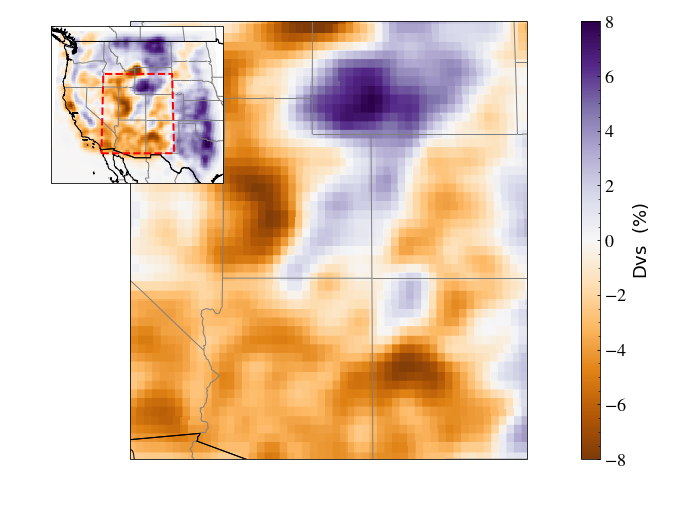

In [77]:
import matplotlib.pyplot as plt


proj_tuple =  ('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} )

ds = get_internal_IRIS("internal_geographic_partial") 

c = ds.domain_center
c[0] = 100 

def get_slice():
    p = yt.SlicePlot(ds, "depth", 'dvs',center=c)
    p.set_mpl_projection(proj_tuple)
    p.set_log('dvs',False)
    p.set_zlim('dvs',-8, 8)
    p.set_cmap('dvs','PuOr')
    return p


def add_features(carto_ax):
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_1_states_provinces_lines', '10m',
            edgecolor='gray', facecolor='none'))
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none'))
    
def add_zoombox_outline(carto_ax, zoom_extents, **plot_kwargs):    
    xlocs = [zoom_extents[0], zoom_extents[1], zoom_extents[1], 
             zoom_extents[0], zoom_extents[0]]
    ylocs = [zoom_extents[2], zoom_extents[2], zoom_extents[3],
             zoom_extents[3], zoom_extents[2] ]
    carto_ax.plot(xlocs, ylocs, transform=ccrs.PlateCarree(), **plot_kwargs)
    

    
zoom_extents = (-117, -104, 32, 44)

p = get_slice()
p._setup_plots()
p.plots["dvs"].axes.set_extent(zoom_extents)
add_features(p.plots["dvs"].axes)
proj = p.plots["dvs"].axes.projection


new_ax_box = [0.05, 0.65, 0.3, 0.3]
ax2 = p.plots["dvs"].figure.add_axes(new_ax_box, 
                                     projection=proj)

p2 = get_slice()
p2.plots["dvs"].axes = ax2
p2.plots["dvs"].figure = p.plots["dvs"].figure
p2.plots["dvs"].hide_colorbar()

p2._setup_plots()
add_features(ax2)
add_zoombox_outline(ax2, zoom_extents,color='r', linestyle='--', linewidth=2)
ax2.set_position(new_ax_box) # hmm, seems to lose the loc. reset it.


p

In [73]:
p.save("niiiiiiiiiiiiiiiiiice.png")

yt : [INFO     ] 2021-05-13 16:41:57,010 Saving plot niiiiiiiiiiiiiiiiiice.png


['niiiiiiiiiiiiiiiiiice.png']

yt : [INFO     ] 2021-05-13 16:55:43,503 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-13 16:55:43,504 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2021-05-13 16:55:43,505 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2021-05-13 16:55:43,505 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2021-05-13 16:55:43,506 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2021-05-13 16:55:43,507 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2021-05-13 16:55:43,624 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 16:55:43,624 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 16:55:43,625 xlim = -125.750000 -95.500000
yt : [INFO     ] 2021-05-13 16:55:43,625 ylim = 27.500000 50.500000
yt : [INFO     ] 2021-05-13 16:55:43,626 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2021-05-13 16:55:43,654 Plo


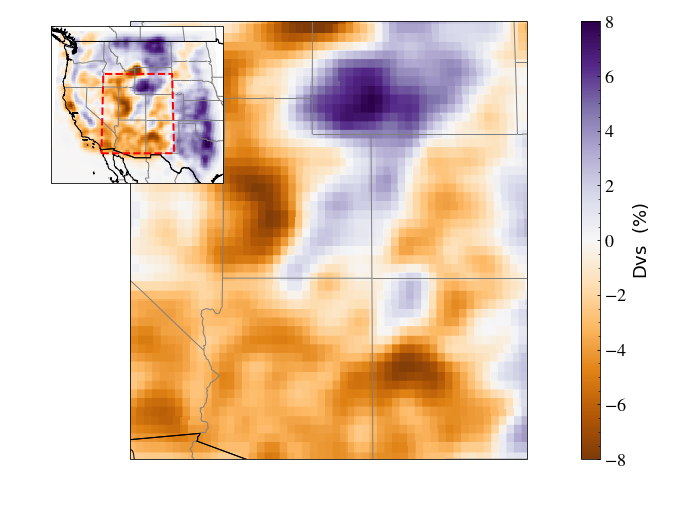

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import yt
import os
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs


ddir = os.path.join(yt.config.ytcfg.get('yt','test_data_dir'), 'sample_nc')
             
datasets = {
    "internal_geographic_partial": os.path.join(ddir,'wUS-SH-2010_percent.nc'), 
    "internal_geographic_global": os.path.join(ddir,'GYPSUM_percent.nc'), 
}

def get_internal_IRIS(case,latrng=None,lonrng=None):
    # both datasets have the same variables and dimension order
    
    fi = datasets[case]

    with xr.open_dataset(fi) as xr_ds:
        dvs = xr_ds.dvs.to_masked_array().data
        deprng = [xr_ds.depth.data.min(), xr_ds.depth.data.max()]
        if latrng is None:
            lonrng=[xr_ds.longitude.data.min(), xr_ds.longitude.data.max()]
        if latrng is None:
            latrng=[xr_ds.latitude.data.min(), xr_ds.latitude.data.max()]

    data = {'dvs': (dvs, "%")}
    
    bbox = np.array([
      deprng,   
      latrng,
      lonrng
    ])

    dims = ['depth', 'latitude', 'longitude']

    return yt.load_uniform_grid(data, data['dvs'][0].shape, 1.0, 
                                geometry=("internal_geographic", dims),
                                bbox=bbox)

# load the dataset
ds = get_internal_IRIS("internal_geographic_partial") 

# set our slice center
c = ds.domain_center
c[0] = 100 

# and a projection
proj_tuple =  ('Robinson', () , {'central_longitude':float(c[2].value), 'globe':None} )

# the extents of the large zoomed map
zoom_extents = (-117, -104, 32, 44)



def get_slice():
    p = yt.SlicePlot(ds, "depth", 'dvs',center=c)
    p.set_mpl_projection(proj_tuple)
    p.set_log('dvs',False)
    p.set_zlim('dvs',-8, 8)
    p.set_cmap('dvs','PuOr')
    return p

def add_features(carto_ax):
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_1_states_provinces_lines', '10m',
            edgecolor='gray', facecolor='none'))
    carto_ax.add_feature(cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_countries', '10m',
            edgecolor='black', facecolor='none'))
    
def add_zoombox_outline(carto_ax, zoom_extents, **plot_kwargs):    
    xlocs = [zoom_extents[0], zoom_extents[1], zoom_extents[1], 
             zoom_extents[0], zoom_extents[0]]
    ylocs = [zoom_extents[2], zoom_extents[2], zoom_extents[3],
             zoom_extents[3], zoom_extents[2] ]
    carto_ax.plot(xlocs, ylocs, transform=ccrs.PlateCarree(), **plot_kwargs)


p = get_slice()
p._setup_plots()
p.plots["dvs"].axes.set_extent(zoom_extents)
add_features(p.plots["dvs"].axes)
proj = p.plots["dvs"].axes.projection


locator_box = [0.05, 0.65, 0.3, 0.3]
ax2 = p.plots["dvs"].figure.add_axes(locator_box, 
                                     projection=proj)

p2 = get_slice()
p2.plots["dvs"].axes = ax2
p2.plots["dvs"].figure = p.plots["dvs"].figure
p2.plots["dvs"].hide_colorbar()

p2._setup_plots()
add_features(ax2)
add_zoombox_outline(ax2, zoom_extents,color='r', linestyle='--', linewidth=2)
ax2.set_position(locator_box) # hmm, seems to lose the loc. reset it.


p